In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import prince
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, roc_curve, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import seaborn as sns
from itertools import product
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean
import tensorflow as tf
import shap
%matplotlib inline
from xgboost import XGBClassifier

In [2]:
plt.style.use("seaborn")

## Import the data

In [3]:
IND_a= pd.read_csv("../Datasets/Brazil_2021_access.csv")
IND_u= pd.read_csv('../Datasets/Brazil_2021_usage.csv')
y= IND_a['fin34a'].copy()
w= IND_a['wgt'].copy()
IND_a= IND_a.drop(columns=['wgt','fin34a'])
IND_u= IND_u.drop(columns=['wgt','fin34a'])

In [4]:
y.value_counts()

0    630
1    372
Name: fin34a, dtype: int64

In [5]:
sup= IND_a[IND_a.columns[:4]]
sup

,female,age,educ,inc_q
0,2,2.0,2,3
1,2,2.0,3,5
2,1,4.0,1,1
3,2,1.0,2,3
4,2,1.0,2,5
...,...,...,...,...
997,1,3.0,3,5
998,1,5.0,3,5
999,1,1.0,2,3
1000,2,1.0,2,2


In [6]:
contingency_table = pd.crosstab(IND_a['educ'], IND_a['inc_q'])
contingency_table

inc_q,1,2,3,4,5
educ,,,,,
1,36,37,31,22,16
2,76,95,95,161,124
3,3,16,22,71,197


In [7]:
IND_a= IND_a.drop(columns= IND_a.columns[:4])
IND_u= IND_u.drop(columns= IND_u.columns[:4])

## Implementing MCA

In [8]:
mca_a = prince.MCA(n_components=9)

# Fit the MCA model to your data
mca_a.fit(IND_a)

# Transform the data into MCA coordinates
IND_a_index = mca_a.transform(IND_a)
new_column_names_a = {i: f'aPC{i+1}' for i in IND_a_index.columns}
IND_a_index = IND_a_index.rename(columns=new_column_names_a)
IND_a_index

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,aPC7,aPC8,aPC9
0,-0.383951,0.035316,0.813000,-0.165987,0.473151,0.267239,0.096039,-0.023409,-0.004436
1,-0.212815,-0.034567,0.069049,-0.272860,-0.437947,0.014639,-0.097700,-0.023099,-0.020966
2,0.534297,0.814597,-0.036003,0.638880,-0.019522,-0.155068,-1.041755,-0.092450,0.514340
3,0.651999,-0.446747,-0.004166,0.195031,-0.289067,0.152972,0.265030,0.824044,0.402634
4,0.234648,-0.174983,0.200529,0.169696,0.284134,1.019169,0.209762,0.475680,-0.183271
...,...,...,...,...,...,...,...,...,...
997,-0.212815,-0.034567,0.069049,-0.272860,-0.437947,0.014639,-0.097700,-0.023099,-0.020966
998,-0.156340,0.032217,-0.563290,0.528997,-0.083663,0.182419,0.028471,-0.178778,-0.017326
999,-0.139512,0.185842,0.712720,0.635082,-0.082158,0.304766,0.163729,-0.195432,-0.012660
1000,0.266738,-0.185576,-0.554141,0.597386,-0.025218,0.155178,0.185513,0.404860,-0.202703


In [9]:
mca_u = prince.MCA(n_components=32)

# Fit the MCA model to your data
mca_u.fit(IND_u)

# Transform the data into MCA coordinates
IND_u_index = mca_u.transform(IND_u)
new_column_names_u = {i: f'uPC{i+1}' for i in IND_u_index.columns}
IND_u_index = IND_u_index.rename(columns=new_column_names_u)
IND_u_index

,uPC1,uPC2,uPC3,uPC4,uPC5,uPC6,uPC7,uPC8,uPC9,uPC10,...,uPC23,uPC24,uPC25,uPC26,uPC27,uPC28,uPC29,uPC30,uPC31,uPC32
0,-0.496765,0.437846,0.186668,0.165309,0.269142,0.203949,-0.115103,0.139799,-0.185630,-0.071477,...,0.017913,-0.113955,0.036521,-0.014955,-0.001549,0.078152,0.082531,-0.007818,-0.040736,0.011071
1,-0.404890,-0.283647,0.251635,-0.145523,-0.168835,0.007588,-0.057714,0.130942,-0.177445,0.038708,...,-0.115173,-0.035949,-0.032681,0.011764,-0.077038,-0.103472,0.056060,0.021148,0.002409,-0.019703
2,0.717705,-0.124176,-0.296727,0.176973,-0.121634,-0.160270,-0.031224,-0.127544,-0.228804,-0.238017,...,0.108059,0.029223,-0.006239,0.223287,0.016126,-0.085828,-0.002635,-0.029309,0.070776,0.004721
3,0.521632,-0.103606,0.410283,-0.259232,0.402952,-0.094649,-0.249443,0.282569,-0.138736,-0.099646,...,0.039301,-0.032413,0.027077,0.019065,0.017310,-0.146209,0.122249,-0.101652,-0.045799,-0.113686
4,0.179379,0.071983,0.430689,-0.114070,-0.241728,0.163020,0.031464,-0.348969,0.045533,0.461673,...,-0.129444,-0.034038,0.185471,-0.122569,0.043385,0.005937,0.103874,-0.137305,0.035804,0.024530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,-0.422586,-0.155905,-0.094319,-0.059685,-0.181407,0.054767,-0.008551,-0.050227,0.053615,-0.080231,...,-0.164103,-0.034366,-0.004665,0.000152,0.058698,-0.013658,-0.002265,0.006711,0.002476,-0.004648
998,-0.158864,-0.049361,0.022359,-0.125526,-0.116518,-0.109034,0.372073,0.130150,0.293859,0.038329,...,0.038352,0.100169,0.129676,0.019500,0.056425,0.027520,-0.086304,-0.038829,-0.029035,0.034962
999,0.197613,0.040699,-0.218046,-0.142425,0.059256,0.417259,-0.002690,-0.009342,-0.094701,0.120317,...,0.285188,0.180004,-0.122023,0.015083,-0.054038,-0.015505,0.099423,-0.006014,-0.064099,0.006383
1000,0.196349,-0.104901,0.316906,-0.240756,-0.109040,-0.191577,0.068595,0.065928,0.086916,0.026284,...,-0.089516,0.115607,0.235978,-0.081234,-0.001070,-0.006393,-0.049083,-0.137948,0.040573,0.055624


In [10]:
X = pd.concat([IND_a_index, IND_u_index, sup], axis=1)
X

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,aPC7,aPC8,aPC9,uPC1,...,uPC27,uPC28,uPC29,uPC30,uPC31,uPC32,female,age,educ,inc_q
0,-0.383951,0.035316,0.813000,-0.165987,0.473151,0.267239,0.096039,-0.023409,-0.004436,-0.496765,...,-0.001549,0.078152,0.082531,-0.007818,-0.040736,0.011071,2,2.0,2,3
1,-0.212815,-0.034567,0.069049,-0.272860,-0.437947,0.014639,-0.097700,-0.023099,-0.020966,-0.404890,...,-0.077038,-0.103472,0.056060,0.021148,0.002409,-0.019703,2,2.0,3,5
2,0.534297,0.814597,-0.036003,0.638880,-0.019522,-0.155068,-1.041755,-0.092450,0.514340,0.717705,...,0.016126,-0.085828,-0.002635,-0.029309,0.070776,0.004721,1,4.0,1,1
3,0.651999,-0.446747,-0.004166,0.195031,-0.289067,0.152972,0.265030,0.824044,0.402634,0.521632,...,0.017310,-0.146209,0.122249,-0.101652,-0.045799,-0.113686,2,1.0,2,3
4,0.234648,-0.174983,0.200529,0.169696,0.284134,1.019169,0.209762,0.475680,-0.183271,0.179379,...,0.043385,0.005937,0.103874,-0.137305,0.035804,0.024530,2,1.0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,-0.212815,-0.034567,0.069049,-0.272860,-0.437947,0.014639,-0.097700,-0.023099,-0.020966,-0.422586,...,0.058698,-0.013658,-0.002265,0.006711,0.002476,-0.004648,1,3.0,3,5
998,-0.156340,0.032217,-0.563290,0.528997,-0.083663,0.182419,0.028471,-0.178778,-0.017326,-0.158864,...,0.056425,0.027520,-0.086304,-0.038829,-0.029035,0.034962,1,5.0,3,5
999,-0.139512,0.185842,0.712720,0.635082,-0.082158,0.304766,0.163729,-0.195432,-0.012660,0.197613,...,-0.054038,-0.015505,0.099423,-0.006014,-0.064099,0.006383,1,1.0,2,3
1000,0.266738,-0.185576,-0.554141,0.597386,-0.025218,0.155178,0.185513,0.404860,-0.202703,0.196349,...,-0.001070,-0.006393,-0.049083,-0.137948,0.040573,0.055624,2,1.0,2,2


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 64)

## Logistic regression

In [12]:
lr = LogisticRegression(solver='newton-cg', max_iter=200)

#Setting the range for class weights
weights= [.2* i for i in range(1, 101)]
weights= list(product(weights, weights))

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0: 3.6, 1:5}], 
              'C': [i for i in range(1,2)]}

#Fitting grid search to the train data with 5 folds
grid_search_lr = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [13]:
print('Best parameters:', grid_search_lr.best_params_)
print('Best score:', grid_search_lr.best_score_)

Best parameters: {'C': 1, 'class_weight': {0: 3.6, 1: 5}}
Best score: 0.9261722982432372


In [14]:
best_lr = LogisticRegression(**grid_search_lr.best_params_)
best_lr.fit(X_train, y_train)

proba = best_lr.predict_proba(X_test)
y_= proba[:,1]

auc1 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc1)

# Calculate precision, recall, and F1-score
target_names = ["0", "1"]
treshold= 0.5
y_pred = (y_ >= treshold).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9768624195891265
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       122
           1       0.88      0.97      0.92        79

    accuracy                           0.94       201
   macro avg       0.93      0.94      0.93       201
weighted avg       0.94      0.94      0.94       201



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


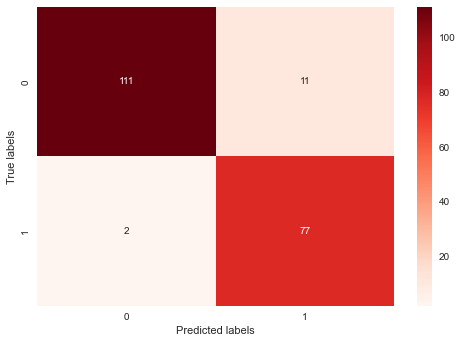

In [15]:
cm1 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [16]:
acc_1= accuracy_score(y_test, y_pred)
pre_1= precision_score(y_test, y_pred)
rec_1= recall_score(y_test, y_pred)
f_1_1= f1_score(y_test, y_pred)

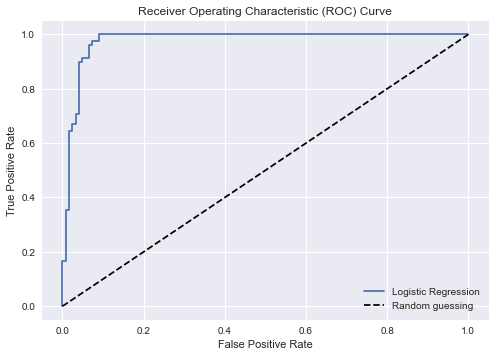

In [17]:
fpr1, tpr1, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Random Forest

In [18]:
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))
param_grid = {
    'n_estimators': [87],
    'max_depth': [7],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_features': ['sqrt'],
    'class_weight': [{0: .19, 1: .67}]
}
rf = RandomForestClassifier(random_state= 42)

In [19]:
grid_search_rf = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
best_rf = RandomForestClassifier(**grid_search_rf.best_params_)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
proba= best_rf.predict_proba(X_test)
y_=proba[:,1]
print(f'Best hyperparameters: {grid_search_rf.best_params_}')
print('Best score:', grid_search_rf.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'class_weight': {0: 0.19, 1: 0.67}, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 87}
Best score: 0.872204748048763


In [20]:
auc2 = roc_auc_score(y_test, proba[:,1], multi_class='auto')
print('AUC:', auc2)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9649304835028014
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       122
           1       0.89      0.92      0.91        79

    accuracy                           0.93       201
   macro avg       0.92      0.93      0.92       201
weighted avg       0.93      0.93      0.93       201



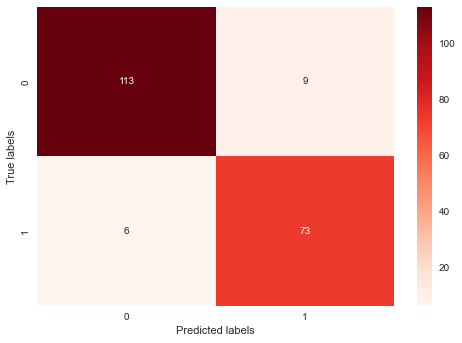

In [21]:
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [22]:
acc_2= accuracy_score(y_test, y_pred)
pre_2= precision_score(y_test, y_pred)
rec_2= recall_score(y_test, y_pred)
f_1_2= f1_score(y_test, y_pred)

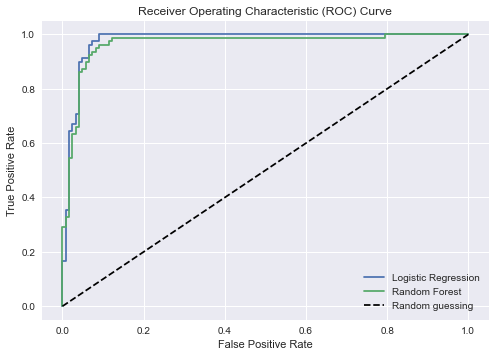

In [23]:
fpr2, tpr2, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## XG Boost

In [24]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale_pos_weight = neg / pos

In [25]:
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)
param_grid = {
    'max_depth': [10],
    'learning_rate': [.1],
    'n_estimators': [376],
    'subsample': [0.5],
    'colsample_bytree': [0.5],
    'reg_alpha': [0.5],
    'reg_lambda': [0.1],
}
grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
print("Best hyperparameters: ", grid_search_xgb.best_params_)
print("Best F1 score: ", grid_search_xgb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 376, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
Best F1 score:  0.9076464467686446


In [26]:
best_xgb = XGBClassifier(**grid_search_xgb.best_params_)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
proba = best_xgb.predict_proba(X_test)
y_= proba[:,1]

In [27]:
auc3 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc3)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9755135920315419
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       122
           1       0.91      0.94      0.92        79

    accuracy                           0.94       201
   macro avg       0.94      0.94      0.94       201
weighted avg       0.94      0.94      0.94       201



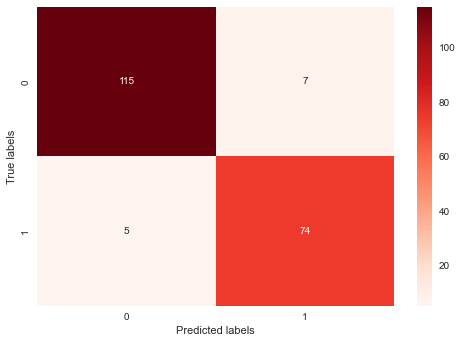

In [28]:
cm3 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm3, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [29]:
acc_3= accuracy_score(y_test, y_pred)
pre_3= precision_score(y_test, y_pred)
rec_3= recall_score(y_test, y_pred)
f_1_3= f1_score(y_test, y_pred)

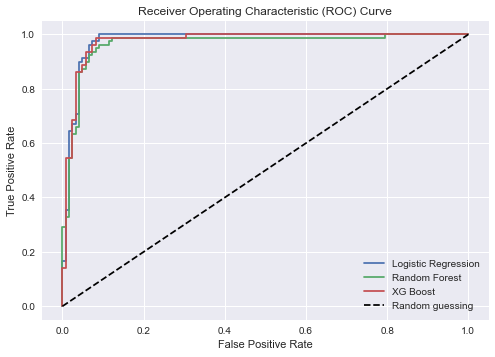

In [30]:
fpr3, tpr3, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot(fpr3, tpr3, label='XG Boost')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Artificial Neural Network

In [31]:
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [32]:
ann.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [33]:
history = ann.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/50
20/20 [==============================] - 2s 20ms/step - loss: 0.6334 - precision: 0.2000 - recall: 0.0042 - val_loss: 0.5768 - val_precision: 0.7143 - val_recall: 0.0877
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.5531 - precision: 0.7290 - recall: 0.4788 - val_loss: 0.5138 - val_precision: 0.7059 - val_recall: 0.6316
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.4888 - precision: 0.7277 - recall: 0.6229 - val_loss: 0.4729 - val_precision: 0.7091 - val_recall: 0.6842
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.4330 - precision: 0.7685 - recall: 0.7034 - val_loss: 0.4387 - val_precision: 0.7119 - val_recall: 0.7368
Epoch 5/50
20/20 [==============================] - 0s 3ms/step - loss: 0.3820 - precision: 0.8000 - recall: 0.7797 - val_loss: 0.3961 - val_precision: 0.8077 - val_recall: 0.7368
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.3293 - precision: 0.8455 

20/20 [==============================] - 0s 4ms/step - loss: 0.0444 - precision: 0.9672 - recall: 1.0000 - val_loss: 0.2590 - val_precision: 0.8966 - val_recall: 0.9123
Epoch 47/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0511 - precision: 0.9710 - recall: 0.9915 - val_loss: 0.2441 - val_precision: 0.8814 - val_recall: 0.9123
Epoch 48/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0434 - precision: 0.9793 - recall: 1.0000 - val_loss: 0.2510 - val_precision: 0.8814 - val_recall: 0.9123
Epoch 49/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0419 - precision: 0.9792 - recall: 0.9958 - val_loss: 0.2714 - val_precision: 0.8947 - val_recall: 0.8947
Epoch 50/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0420 - precision: 0.9712 - recall: 1.0000 - val_loss: 0.2534 - val_precision: 0.8814 - val_recall: 0.9123


In [34]:
y_ = ann.predict(X_test)

7/7 [==============================] - 0s 2ms/step


In [35]:
y_= y_.reshape(y_.shape[0],)

In [36]:
y_pred= np.array([round(i) for i in y_])

In [37]:
auc4 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc4)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9703257937331397
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       122
           1       0.89      0.91      0.90        79

    accuracy                           0.92       201
   macro avg       0.92      0.92      0.92       201
weighted avg       0.92      0.92      0.92       201



In [38]:
acc_4= accuracy_score(y_test, y_pred)
pre_4= precision_score(y_test, y_pred)
rec_4= recall_score(y_test, y_pred)
f_1_4= f1_score(y_test, y_pred)

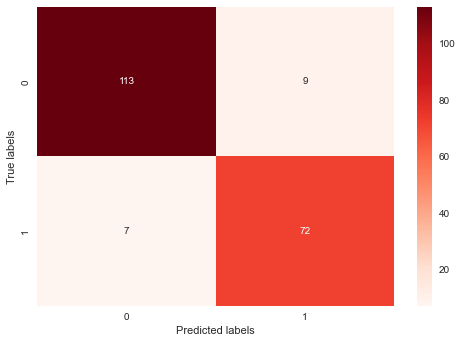

In [39]:
cm4 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm4, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

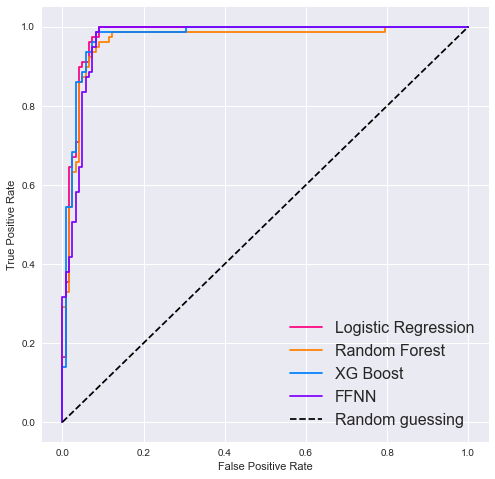

In [40]:
fpr4, tpr4, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr1, tpr1, label='Logistic Regression', color= "#ff007f")
plt.plot(fpr2, tpr2, label='Random Forest', color= "#ff7f00")
plt.plot(fpr3, tpr3, label='XG Boost', color= "#007fff")
plt.plot(fpr4, tpr4, label='FFNN', color= "#7f00ff")
plt.plot([0, 1], [0, 1], linestyle='--', color= "#000000", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(fontsize=16)
plt.savefig("../../images/roc_bra.png")
plt.show()

## Model Evaluations

In [41]:
data= {"Metrics":["Accuracy", "Recall", "Precision", "F1-Score", "AUC"],
       "LR":[round(acc_1,4), round(rec_1,4), round(pre_1,4), round(f_1_1,4), round(auc1,4)], 
       "RF":[round(acc_2,4), round(rec_2,4), round(pre_2,4), round(f_1_2,4), round(auc2,4)], 
       "XGB":[round(acc_3,4), round(rec_3,4), round(pre_3,4), round(f_1_3,4), round(auc3,4)], 
       "FFNN":[round(acc_4,4), round(rec_4,4), round(pre_4,4), round(f_1_4,4), round(auc4,4)]}
df = pd.DataFrame(data)
latex_code = df.to_latex(index=False)

# Print the LaTeX code
print(latex_code)

\begin{tabular}{lrrrr}
\toprule
  Metrics &     LR &     RF &    XGB &   FFNN \\
\midrule
 Accuracy & 0.9353 & 0.9254 & 0.9403 & 0.9204 \\
   Recall & 0.9747 & 0.9241 & 0.9367 & 0.9114 \\
Precision & 0.8750 & 0.8902 & 0.9136 & 0.8889 \\
 F1-Score & 0.9222 & 0.9068 & 0.9250 & 0.9000 \\
      AUC & 0.9769 & 0.9649 & 0.9755 & 0.9703 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Build the index

In [42]:
eig_a= mca_a.eigenvalues_
IND_a_index["access"]= sum([IND_a_index[IND_a_index.columns[i]]*eig_a[i] for i in range(len(eig_a))])
eig_u= mca_u.eigenvalues_
IND_u_index["usage"]= sum([IND_u_index[IND_u_index.columns[i]]*eig_u[i] for i in range(len(eig_u)) ])

In [43]:
IND_fin= pd.concat([IND_a_index["access"], IND_u_index["usage"], sup, y], axis=1)

In [44]:
IND_fin["access"]= IND_fin["access"]*w
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(-1.020871844492418, 9.235110389300644, 0.19941299921554667)

In [45]:
IND_fin["access"] -= min(IND_fin["access"])
IND_fin["access"] /= max(IND_fin["access"])

In [46]:
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(0.0, 1.0, 0.1189827376735476)

In [47]:
IND_fin["usage"]= IND_fin["usage"]*w
min(IND_fin["usage"]), max(IND_fin["usage"]), mean(IND_fin["usage"])

(-0.36731715693573747, 0.9881239568082554, 0.03800227297371325)

In [48]:
IND_fin["usage"] -= min(IND_fin["usage"])
IND_fin["usage"] /= max(IND_fin["usage"])

In [49]:
IND_fin["access"] = 1- IND_fin["access"]
IND_fin["usage"] = 1- IND_fin["usage"]

In [50]:
IND_fin["index"]= (IND_fin['access'] + IND_fin['usage'])/2

In [51]:
fin_0= IND_fin[IND_fin["fin34a"]==0].copy()
fin_1= IND_fin[IND_fin["fin34a"]==1].copy()

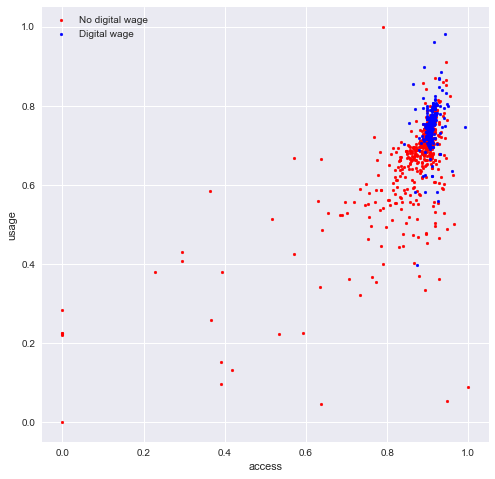

In [52]:
plt.figure(figsize=(8,8))
plt.scatter(fin_0["access"], fin_0["usage"], label= "No digital wage", s=32, color="#ff0000",
            marker='.')
plt.scatter(fin_1["access"], fin_1["usage"], label= "Digital wage", s=32, color="#0000ff",
            marker='.')
plt.xlabel("access")
plt.ylabel("usage")
plt.legend()
#plt.xlim([0.55,1.05])
#plt.ylim([0.35,1.05])
plt.savefig('../../images/find_bra')
plt.show()

In [53]:
IND_fin['access'].describe()

count    1002.000000
mean        0.881017
std         0.097258
min         0.000000
25%         0.891077
50%         0.904372
75%         0.908598
max         1.000000
Name: access, dtype: float64

In [54]:
IND_fin['usage'].describe()

count    1002.000000
mean        0.700969
std         0.104785
min         0.000000
25%         0.686376
50%         0.727541
75%         0.752129
max         1.000000
Name: usage, dtype: float64

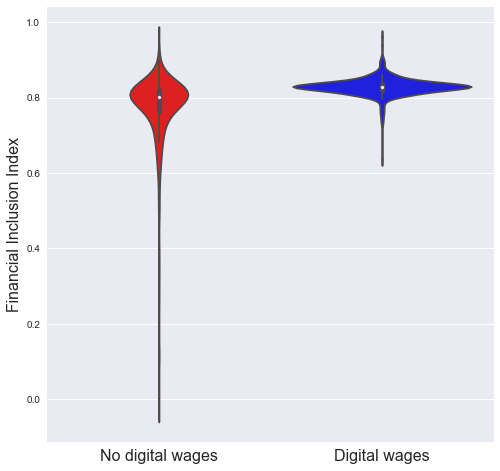

In [55]:
colors = ["#ff0000", "#0000ff"]
plt.figure(figsize=(8, 8))
sns.violinplot(x='fin34a', y='index', data=IND_fin, palette= colors)
custom_category_names = ['No digital wages', 'Digital wages']
plt.xticks(range(len(custom_category_names)), custom_category_names, fontsize=16)
plt.xlabel('')
plt.ylabel('Financial Inclusion Index', fontsize=16)

plt.savefig('../../images/ind_bra')

# Show the plot
plt.show()

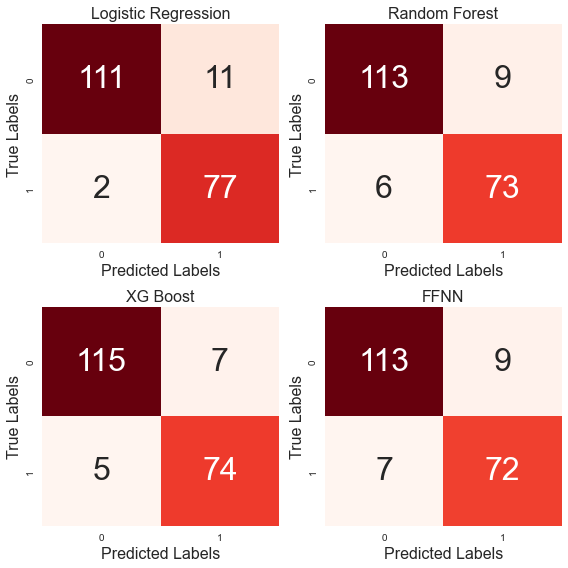

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
cm= [cm1, cm2, cm3, cm4]
mods= ["Logistic Regression", "Random Forest", "XG Boost", "FFNN"]
# Compute and plot confusion matrices
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(cm[i], annot=True, cmap="Reds", fmt='d', ax=ax, cbar=False, 
                annot_kws={"fontsize": 32})
    ax.set_title(f"{mods[i]}", fontsize=16)
    ax.set_xlabel("Predicted Labels", fontsize=16)
    ax.set_ylabel("True Labels", fontsize=16)

# Adjust subplot spacing
plt.tight_layout()
plt.savefig('../../images/comat_bra.png')
# Display the plot
plt.show()

## Feature importance

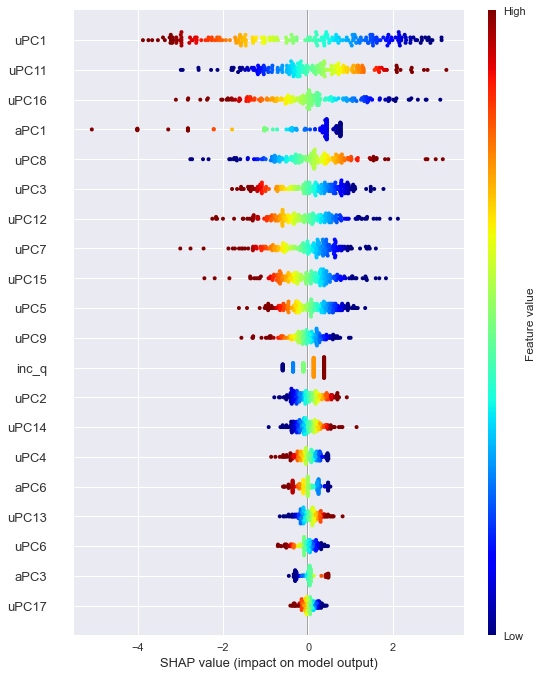

In [65]:
explainer = shap.Explainer(best_lr, X_train)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test, cmap= "jet")

In [58]:
u= mca_u.column_contributions_
u= u.rename(columns=new_column_names_u)
a= mca_a.column_contributions_
a= a.rename(columns=new_column_names_a)

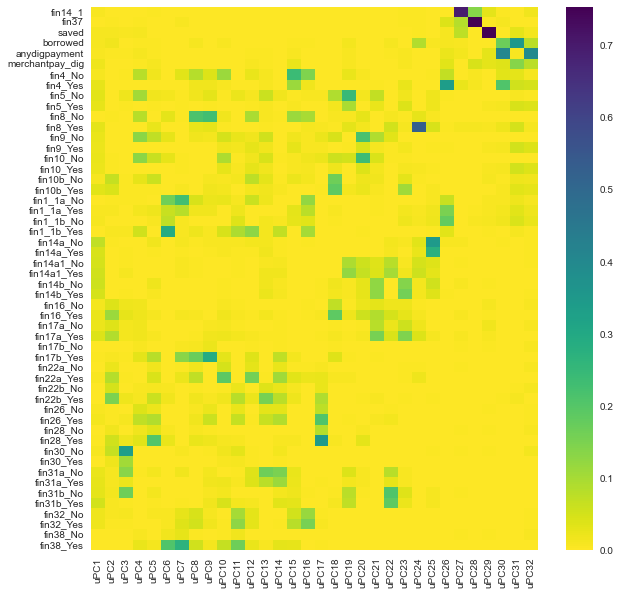

In [59]:
plt.figure(figsize=(10,10))
sns.heatmap(u, annot=False, cmap="viridis_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/us_bra.png')
plt.show()

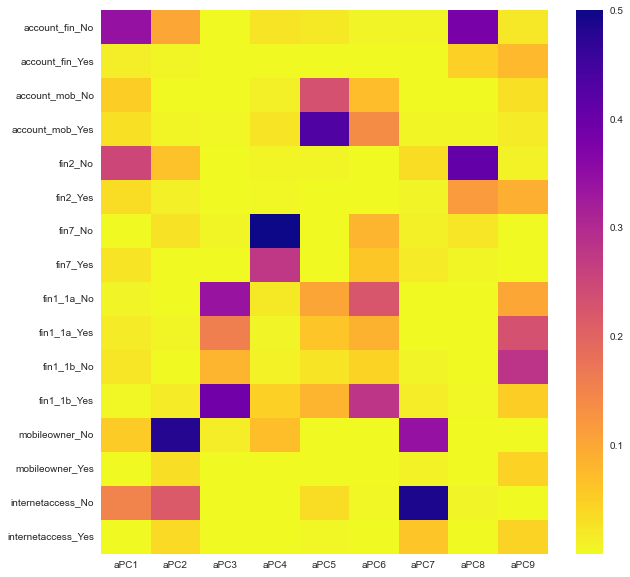

In [60]:
plt.figure(figsize=(10,10))
sns.heatmap(a, annot=False, cmap="plasma_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/acc_bra.png')
plt.show()

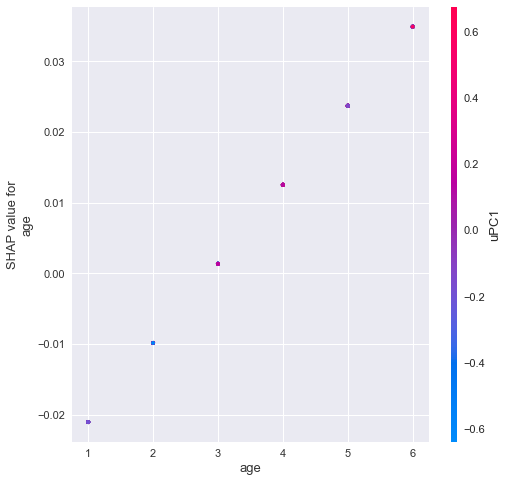

In [61]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('age', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

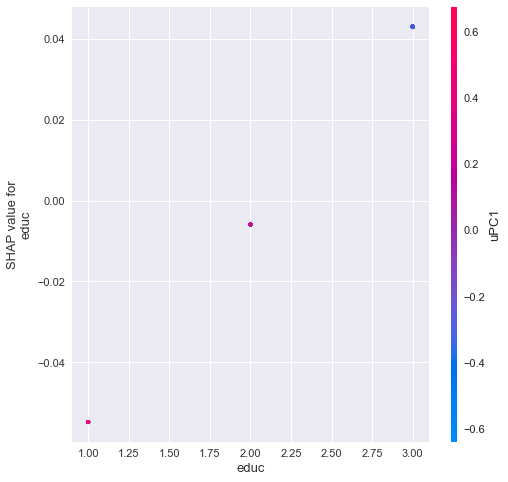

In [62]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('educ', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

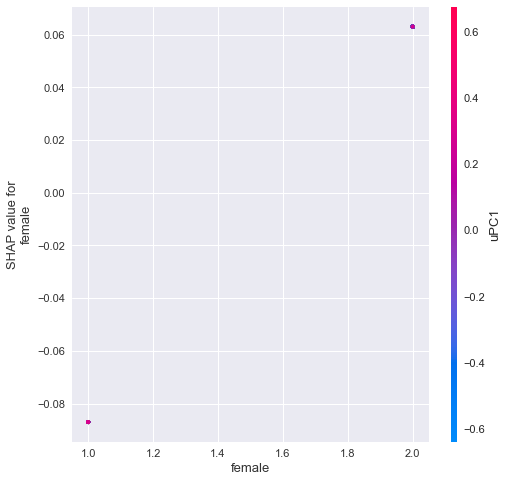

In [63]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('female', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

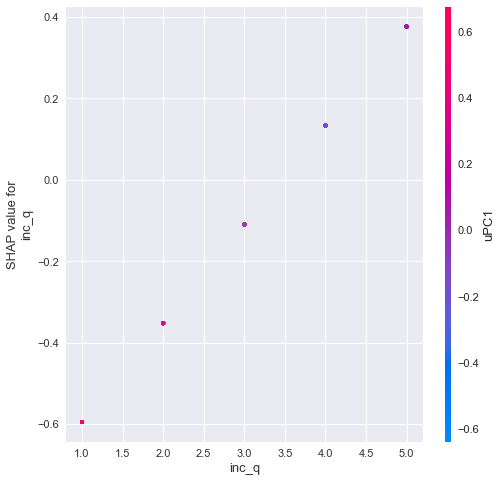

In [64]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('inc_q', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()